# MNE : Basics of source localization

`
Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
         Denis Engemann <denis.engemann@gmail.com>
`

In [3]:
# add plot inline in the page
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import mne
mne.set_log_level('WARNING')

## Process MEG data

In [5]:
from mne.datasets import sample
data_path = sample.data_path()
# data_path = '/media/libre/MNE-sample-data'

raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

raw = mne.io.Raw(raw_fname)
print raw

<RawFIF  |  n_channels x n_times : 376 x 41700>


Looking at meta data, a.k.a. measurement info, such sampling frequency, channels etc.

In [6]:
print raw.info['sfreq']

150.153747559


### Define epochs and compute ERP/ERF

First look for events / triggers

In [7]:
events = mne.find_events(raw, stim_channel='STI 014')
print events[:7]  # display the first 7 lines

[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]
 [7506    0    3]
 [7612    0    1]]


In [8]:
event_id = dict(aud_r=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info['bads'] = ['MEG 2443', 'EEG 053']
picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=True,
                            exclude='bads')
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=reject)
print epochs

<Epochs  |  n_events : 72 (good & bad), tmin : -0.2 (s), tmax : 0.5 (s), baseline : (None, 0)>


## Compute noise covariance

In [9]:
noise_cov = mne.compute_covariance(epochs, tmax=0., method=['shrunk', 'empirical'])
print noise_cov.data.shape

(305, 305)


/Users/dengemann/anaconda/envs/mnedev/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


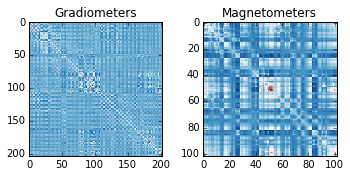

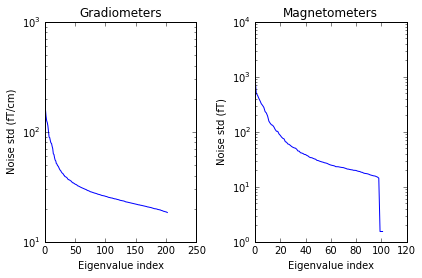

(<matplotlib.figure.Figure at 0x105fd0a90>,
 <matplotlib.figure.Figure at 0x11105f090>)

In [10]:
mne.viz.plot_cov(noise_cov, raw.info)

## Compute the evoked response

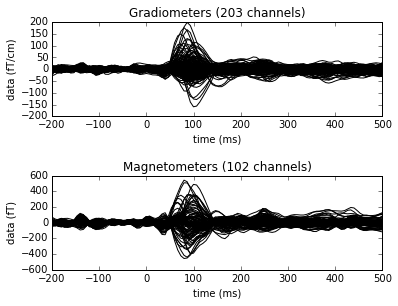

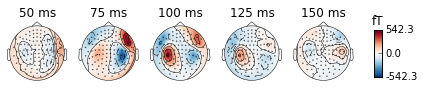

In [11]:
evoked = epochs.average()
evoked.plot()
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='mag');

# Show whitening

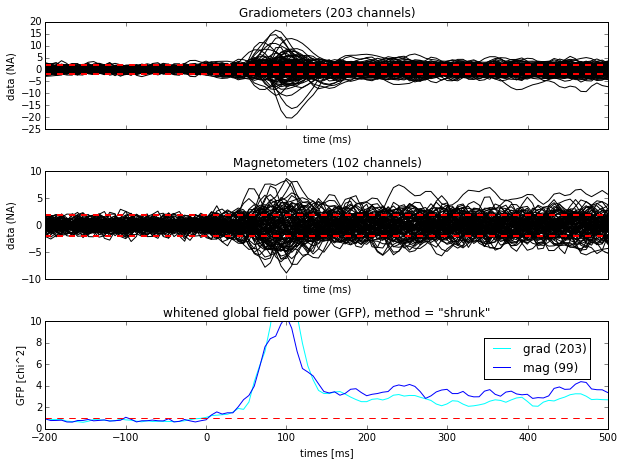

In [12]:
evoked.plot_white(noise_cov);

## Inverse modeling: MNE and dSPM on evoked and raw data

Import the required functions:

In [16]:
from mne.forward import read_forward_solution
from mne.minimum_norm import (make_inverse_operator, apply_inverse,
                              write_inverse_operator)

## Read the forward solution and compute the inverse operator

In [17]:
fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fname_fwd, surf_ori=True)

# Restrict forward solution as necessary for MEG
fwd = mne.pick_types_forward(fwd, meg=True, eeg=False)

# make an M/EEG, MEG-only, and EEG-only inverse operators
info = evoked.info
inverse_operator = make_inverse_operator(info, fwd, noise_cov,
                                         loose=0.2, depth=0.8)

write_inverse_operator('sample_audvis-meg-oct-6-inv.fif',
                       inverse_operator)

## Compute inverse solution

In [18]:
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stc = apply_inverse(evoked, inverse_operator, lambda2,
                    method=method, pick_ori=None)
print stc

<SourceEstimate  |  7498 vertices, subject : sample, tmin : -199.795213158 (ms), tmax : 499.488032896 (ms), tstep : 6.65984043861 (ms), data size : 7498 x 106>


In [13]:
stc.data.shape

(7498, 106)

## Show the result

In [19]:
%matplotlib
subjects_dir = data_path + '/subjects'
brain = stc.plot(surface='inflated', hemi='rh', subjects_dir=subjects_dir)
brain.set_data_time_index(45)
brain.scale_data_colormap(fmin=8, fmid=12, fmax=15, transparent=True)
brain.show_view('lateral')

Using matplotlib backend: MacOSX
Updating smoothing matrix, be patient..


INFO:surfer:Updating smoothing matrix, be patient..


Smoothing matrix creation, step 1


INFO:surfer:Smoothing matrix creation, step 1


Smoothing matrix creation, step 2


INFO:surfer:Smoothing matrix creation, step 2


Smoothing matrix creation, step 3


INFO:surfer:Smoothing matrix creation, step 3


Smoothing matrix creation, step 4


INFO:surfer:Smoothing matrix creation, step 4


Smoothing matrix creation, step 5


INFO:surfer:Smoothing matrix creation, step 5


Smoothing matrix creation, step 6


INFO:surfer:Smoothing matrix creation, step 6


Smoothing matrix creation, step 7


INFO:surfer:Smoothing matrix creation, step 7


Smoothing matrix creation, step 8


INFO:surfer:Smoothing matrix creation, step 8


Smoothing matrix creation, step 9


INFO:surfer:Smoothing matrix creation, step 9


Smoothing matrix creation, step 10


INFO:surfer:Smoothing matrix creation, step 10


colormap: fmin=3.98e+00 fmid=4.63e+00 fmax=1.83e+01 transparent=1


INFO:surfer:colormap: fmin=3.98e+00 fmid=4.63e+00 fmax=1.83e+01 transparent=1


colormap: fmin=8.00e+00 fmid=1.20e+01 fmax=1.50e+01 transparent=1


INFO:surfer:colormap: fmin=8.00e+00 fmid=1.20e+01 fmax=1.50e+01 transparent=1


((-7.0167092985348768e-15, 90.0, 518.46453857421875, array([ 0.,  0.,  0.])),
 -90.0)

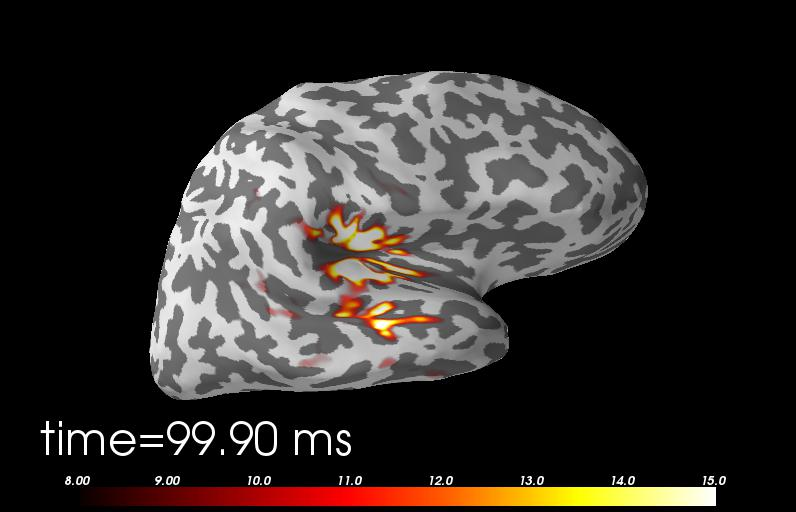

In [20]:
brain.save_image('dspm.jpg')
from IPython.display import Image
Image(filename='dspm.jpg', width=600)

"Morphing" data to an average brain for group studies

In [16]:
stc_fsaverage = stc.morph(subject_to='fsaverage', subjects_dir=subjects_dir)

In [17]:
brain_fsaverage = stc_fsaverage.plot(surface='inflated', hemi='rh',
                                     subjects_dir=subjects_dir)
brain_fsaverage.set_data_time_index(45)
brain_fsaverage.scale_data_colormap(fmin=8, fmid=12, fmax=15, transparent=True)
brain_fsaverage.show_view('lateral')

Updating smoothing matrix, be patient..


INFO:surfer:Updating smoothing matrix, be patient..


Smoothing matrix creation, step 1


INFO:surfer:Smoothing matrix creation, step 1


Smoothing matrix creation, step 2


INFO:surfer:Smoothing matrix creation, step 2


Smoothing matrix creation, step 3


INFO:surfer:Smoothing matrix creation, step 3


Smoothing matrix creation, step 4


INFO:surfer:Smoothing matrix creation, step 4


Smoothing matrix creation, step 5


INFO:surfer:Smoothing matrix creation, step 5


Smoothing matrix creation, step 6


INFO:surfer:Smoothing matrix creation, step 6


Smoothing matrix creation, step 7


INFO:surfer:Smoothing matrix creation, step 7


Smoothing matrix creation, step 8


INFO:surfer:Smoothing matrix creation, step 8


Smoothing matrix creation, step 9


INFO:surfer:Smoothing matrix creation, step 9


Smoothing matrix creation, step 10


INFO:surfer:Smoothing matrix creation, step 10


colormap: fmin=3.65e+00 fmid=4.25e+00 fmax=1.60e+01 transparent=1


INFO:surfer:colormap: fmin=3.65e+00 fmid=4.25e+00 fmax=1.60e+01 transparent=1


colormap: fmin=8.00e+00 fmid=1.20e+01 fmax=1.50e+01 transparent=1


INFO:surfer:colormap: fmin=8.00e+00 fmid=1.20e+01 fmax=1.50e+01 transparent=1


((-7.0167092985348768e-15, 90.0, 430.92617797851562, array([ 0.,  0.,  0.])),
 -90.0)

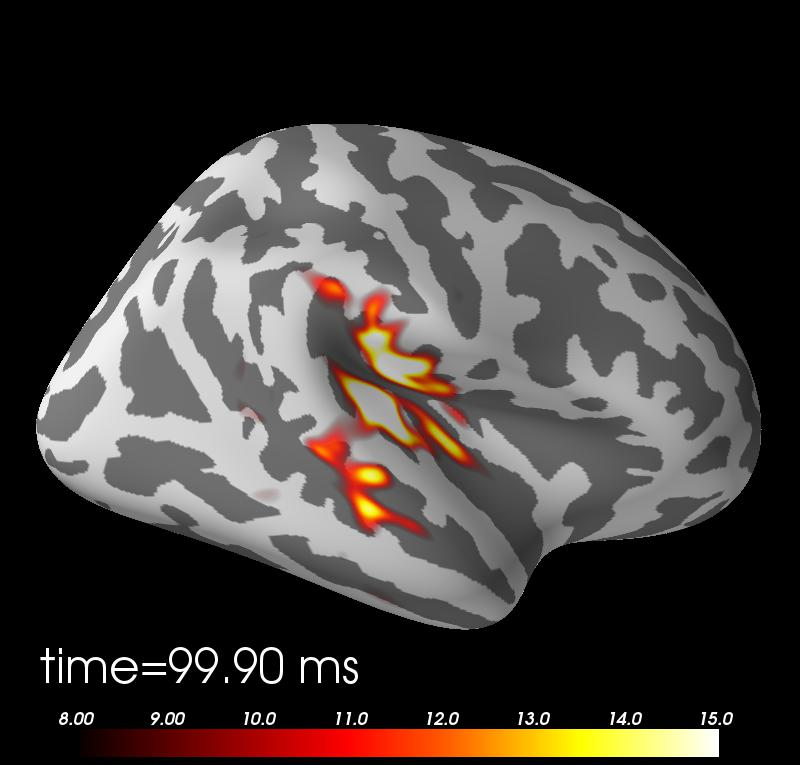

In [18]:
brain_fsaverage.save_image('dspm_fsaverage.jpg')
from IPython.display import Image
Image(filename='dspm_fsaverage.jpg', width=600)

#Solving the inverse problem on raw data or epochs using Freesurfer labels

In [19]:
fname_label = data_path + '/MEG/sample/labels/Aud-lh.label'
label = mne.read_label(fname_label)

Compute inverse solution during the first 15s:

In [20]:
from mne.minimum_norm import apply_inverse_raw, apply_inverse_epochs

start, stop = raw.time_as_index([0, 15])  # read the first 15s of data

stc = apply_inverse_raw(raw, inverse_operator, lambda2, method, label,
                        start, stop)

Plot the dSPM time courses in the label

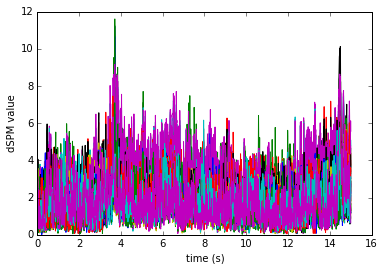

In [21]:
%matplotlib inline
plt.plot(stc.times, stc.data.T)
plt.xlabel('time (s)')
plt.ylabel('dSPM value')

And on epochs:

In [22]:
# Compute inverse solution and stcs for each epoch
# Use the same inverse operator as with evoked data (i.e., set nave)
# If you use a different nave, dSPM just scales by a factor sqrt(nave)

stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method, label,
                            pick_ori="normal", nave=evoked.nave)

stc_evoked = apply_inverse(evoked, inverse_operator, lambda2, method,
                           pick_ori="normal")

stc_evoked_label = stc_evoked.in_label(label)

# Mean across trials but not across vertices in label
mean_stc = np.sum(stcs) / len(stcs)

In [23]:
# compute sign flip to avoid signal cancelation when averaging signed values
flip = mne.label_sign_flip(label, inverse_operator['src'])

label_mean = np.mean(mean_stc.data, axis=0)
label_mean_flip = np.mean(flip[:, np.newaxis] * mean_stc.data, axis=0)

# Average over label (not caring to align polarities here)
label_mean_evoked = np.mean(stc_evoked_label.data, axis=0)

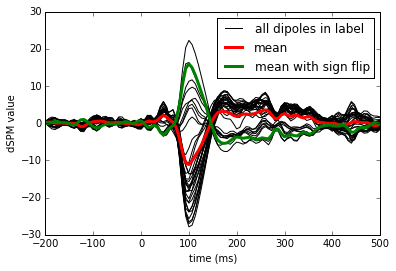

In [24]:
###############################################################################
# View activation time-series to illustrate the benefit of aligning/flipping

times = 1e3 * stcs[0].times  # times in ms

plt.figure()
h0 = plt.plot(times, mean_stc.data.T, 'k')
h1, = plt.plot(times, label_mean, 'r', linewidth=3)
h2, = plt.plot(times, label_mean_flip, 'g', linewidth=3)
plt.legend((h0[0], h1, h2), ('all dipoles in label', 'mean',
                             'mean with sign flip'))
plt.xlabel('time (ms)')
plt.ylabel('dSPM value')
plt.show()

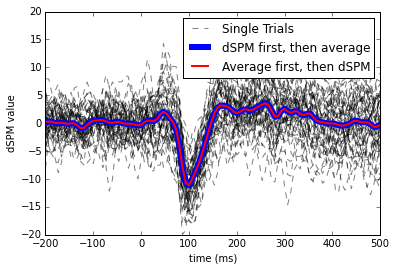

In [25]:
###############################################################################
# Viewing single trial dSPM and average dSPM for unflipped pooling over label
# Compare to (1) Inverse (dSPM) then average, (2) Evoked then dSPM

# Single trial
plt.figure()
for k, stc_trial in enumerate(stcs):
    plt.plot(times, np.mean(stc_trial.data, axis=0).T, 'k--',
             label='Single Trials' if k == 0 else '_nolegend_',
             alpha=0.5)

# Single trial inverse then average.. making linewidth large to not be masked
plt.plot(times, label_mean, 'b', linewidth=6,
         label='dSPM first, then average')

# Evoked and then inverse
plt.plot(times, label_mean_evoked, 'r', linewidth=2,
         label='Average first, then dSPM')

plt.xlabel('time (ms)')
plt.ylabel('dSPM value')
plt.legend()
plt.show()

## Exercises
- Run sLORETA on the same data and compare source localizations
- Run an LCMV beamformer on the same data and compare source localizations

### Going further:
- http://martinos.org/mne/dev/auto_examples/inverse/plot_compute_mne_inverse_epochs_in_label.html
- http://martinos.org/mne/dev/auto_examples/inverse/plot_label_source_activations.html
- http://martinos.org/mne/dev/auto_examples/inverse/plot_label_from_stc.html